In [82]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [83]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

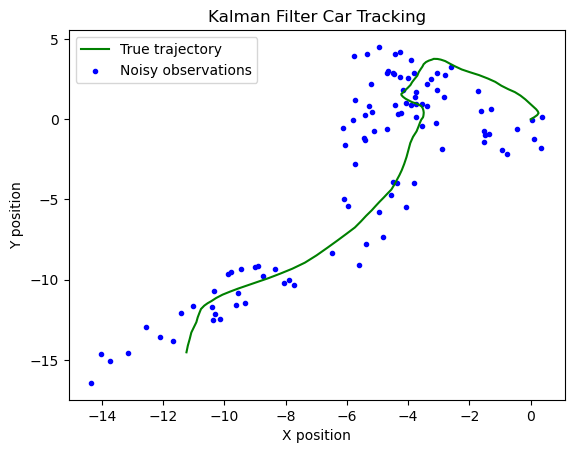

In [84]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [85]:
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints

In [86]:
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_UKF = [m]
P_UKF = [P]

points = MerweScaledSigmaPoints(n=4, alpha=.3, beta=2., kappa=.1)

for y in noisy_observations[1:]:
    sigmas = points.sigma_points(m, P)
    transformed_sigmas = np.array([f(sigma) for sigma in sigmas])

    m_pred = np.sum(points.Wm[:, None] * transformed_sigmas, axis=0)
    P_pred = np.sum([points.Wc[i] * np.outer(transformed_sigmas[i] - m_pred, transformed_sigmas[i] - m_pred) for i in range(len(points.Wc))], axis=0) + Q

    sigmas = points.sigma_points(m_pred, P_pred)
    transformed_sigmas = np.array([h(sigma) for sigma in sigmas])

    mu = np.sum(points.Wm[:, None] * transformed_sigmas, axis=0)
    S = np.sum([points.Wc[i] * np.outer(transformed_sigmas[i] - mu, transformed_sigmas[i] - mu) for i in range(len(points.Wc))], axis=0) + R
    C = np.sum([points.Wc[i] *  np.outer(sigmas[i] - m_pred, transformed_sigmas[i] - mu) for i in range(len(points.Wc))], axis=0)

    K = C @ np.linalg.inv(S)
    m = m_pred + K @ (y - mu)
    P = P_pred - K @ S @ K.T
    
    P_UKF.append(P)
    estimated_trajectory_UKF.append(m)
    
P_UKF = np.array(P_UKF)
estimated_trajectory_UKF = np.array(estimated_trajectory_UKF)

In [87]:
# Extended RTS smoother
n, dim_x = estimated_trajectory_UKF.shape

estimated_trajectory_URTS, P_URTS = estimated_trajectory_UKF.copy(), P_UKF.copy()

for k in range(n-2,-1,-1):
    m = estimated_trajectory_URTS[k]
    P = P_URTS[k]
    
    sigmas = points.sigma_points(m, P)
    transformed_sigmas = np.array([f(sigma) for sigma in sigmas])
    
    m_pred = np.sum(points.Wm[:, None] * transformed_sigmas, axis=0)
    P_pred = np.sum([points.Wc[i] * np.outer(transformed_sigmas[i] - m_pred, transformed_sigmas[i] - m_pred) for i in range(len(points.Wc))], axis=0) + Q
    D = np.sum([points.Wc[i] * np.outer(sigmas[i] - m, transformed_sigmas[i] - m_pred) for i in range(len(points.Wc))], axis=0)
    
    G = D @ np.linalg.inv(P_pred)
    estimated_trajectory_URTS[k] += G @ (estimated_trajectory_URTS[k+1] - m_pred)
    P_URTS[k] += (G @ (P_URTS[k+1] - P_pred)) @ G.T

In [88]:
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.95):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

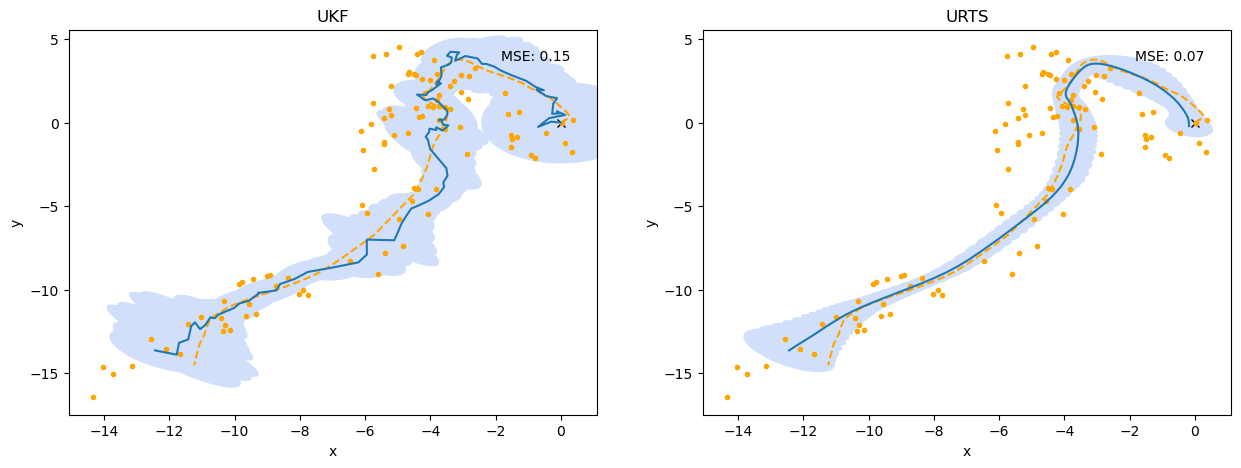

In [89]:
#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(estimated_trajectory_UKF[:, 0], estimated_trajectory_UKF[:, 1])  
ax[0].set_title("UKF")

ax[1].plot(estimated_trajectory_URTS[:, 0], estimated_trajectory_URTS[:, 1])
ax[1].set_title("URTS")

# Compute MSE
UKF_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_UKF[:, :2])**2)
URTS_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_URTS[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(UKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(URTS_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

# # 95% confidence ellipses for the KF
for i in range(0, len(estimated_trajectory_UKF)):
    conf_ellipse(ax[0], estimated_trajectory_UKF[i, :2], P_UKF[i, :2, :2])
    
# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_URTS)):
    conf_ellipse(ax[1], estimated_trajectory_URTS[i, :2], P_URTS[i, :2, :2])
    
plt.show()